**1 || Introduction¶**

# **1 || Introduction**

# **2 || Import Necessaries**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from keras.preprocessing import text
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import DistilBertTokenizerFast
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import TrainingArguments, Trainer

# **3 || Exploratory Data Analysis and Vis stands**

## **3.1 || Load the data**

In [3]:
def load_json_file(filename):
    with open(filename) as f:
        file = json.load(f)
    return file

filename = '/content/intents.json'

intents = load_json_file(filename)

## **3.2 || Extract Info from the Json data file and Store it in dataframe¶**

In [4]:
def create_df():
    df = pd.DataFrame({
        'Pattern' : [],
        'Tag' : []
    })

    return df

df = create_df()
df

,Pattern,Tag


In [5]:
def extract_json_info(json_file, df):

    for intent in json_file['intents']:

        for pattern in intent['patterns']:

            sentence_tag = [pattern, intent['tag']]
            df.loc[len(df.index)] = sentence_tag

    return df

df = extract_json_info(intents, df)
df.head()

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [6]:
df2 = df.copy()
df2.head()

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


## **3.3 || Check the shape of the dataset**

In [7]:
def print_shape_df(df, ds_name="df"):
    print(f"{ds_name} dataset has {df.shape[0]} rows and {df.shape[1]} columns")

print_shape_df(df, "Chatbot")

Chatbot dataset has 960 rows and 2 columns


## **3.4 || Display information about the dataset**

In [8]:
def print_dfInfo(df, ds_name="df"):
    print(f"The info of {ds_name} dataset\n")
    print(df.info())

print_dfInfo(df, "Chatbot")

The info of Chatbot dataset

<class 'pandas.core.frame.DataFrame'>
Index: 960 entries, 0 to 959
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  960 non-null    object
 1   Tag      960 non-null    object
dtypes: object(2)
memory usage: 22.5+ KB
None


## **3.5 || Display Number of Classes**

In [9]:
def num_classes(df, target_col, ds_name="df"):
    print(f"The {ds_name} dataset has {len(df[target_col].unique())} classes")

num_classes(df, 'Tag', "Chatbot")

The Chatbot dataset has 58 classes


## **3.6 || Check the null values in the dataset**

In [10]:
def check_null(df, ds_name='df'):
    print(f"Null Values in each col in the {ds_name} dataset:\n")
    print(df.isnull().sum())

check_null(df, "Chatbot")

Null Values in each col in the Chatbot dataset:

Pattern    0
Tag        0
dtype: int64


## **3.7 || Visualize the Null Values**

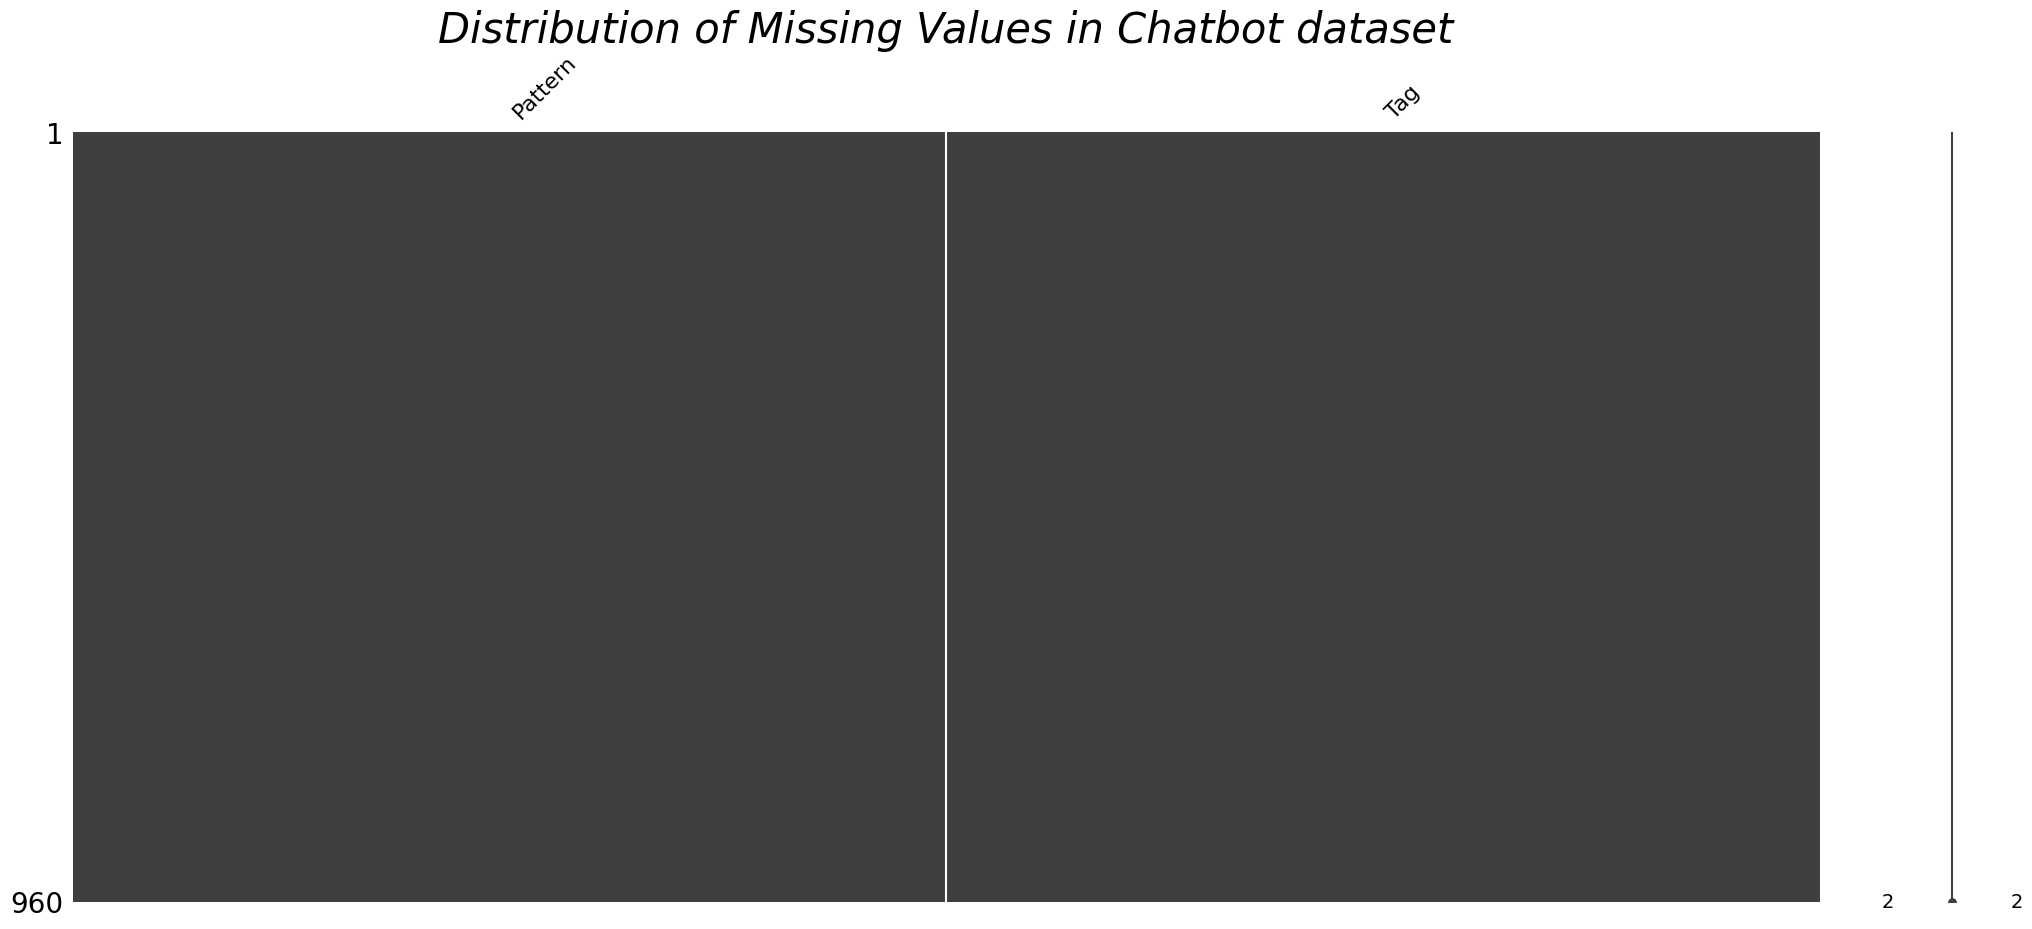

In [11]:
def plot_miss_vals(df, ds_name="df"):
    msno.matrix(df)
    plt.title(f'Distribution of Missing Values in {ds_name} dataset', fontsize=30, fontstyle='oblique')
    plt.show()

plot_miss_vals(df, "Chatbot")

## **3.8 || Visualize the distrbution of our Classes¶**

In [12]:
def count_plot(x, df, title, xlabel, ylabel, width, height, order = None, rotation=False, palette='winter', hue=None):
    ncount = len(df)
    plt.figure(figsize=(width,height))
    ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    ax.yaxis.set_label_position('left')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y),
                ha='center', va='bottom') # set the alignment of the text

    plt.show()

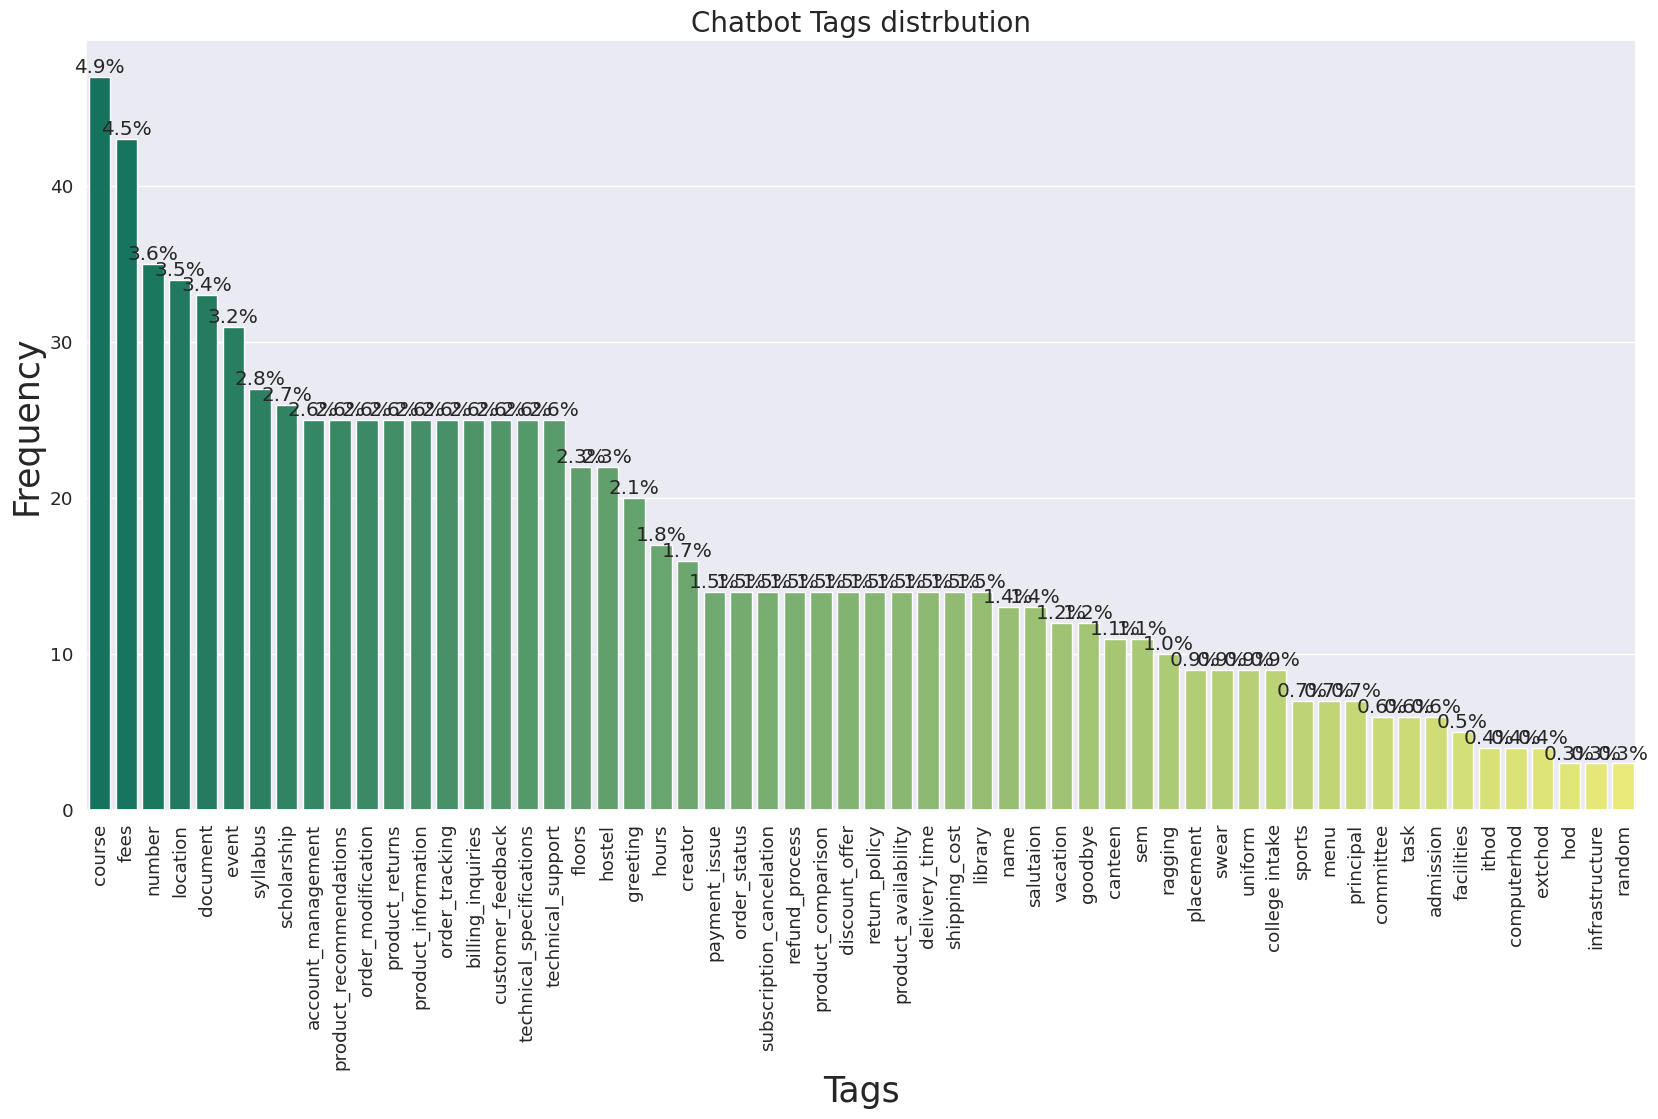

In [13]:
sns.set(font_scale = 1.2)
order = df['Tag'].value_counts().index
count_plot(df['Tag'], df, "Chatbot Tags distrbution", "Tags", "Frequency", 20,10, order=order,rotation=True, palette="summer")

In [14]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
stemmer = PorterStemmer()
ignore_words=['?', '!', ',', '.']

def preprocess_pattern(pattern):
    words = word_tokenize(pattern.lower())
    stemmed_words = [stemmer.stem(word) for word in words if word not in ignore_words]
    return " ".join(stemmed_words)

df['Pattern'] = df['Pattern'].apply(preprocess_pattern)

In [16]:
df.head()

,Pattern,Tag
0,hi,greeting
1,how are you,greeting
2,is anyon there,greeting
3,hello,greeting
4,good day,greeting


In [17]:
print(df['Pattern'].isnull().sum())

0


## **3.9 || Display Word Cloud**

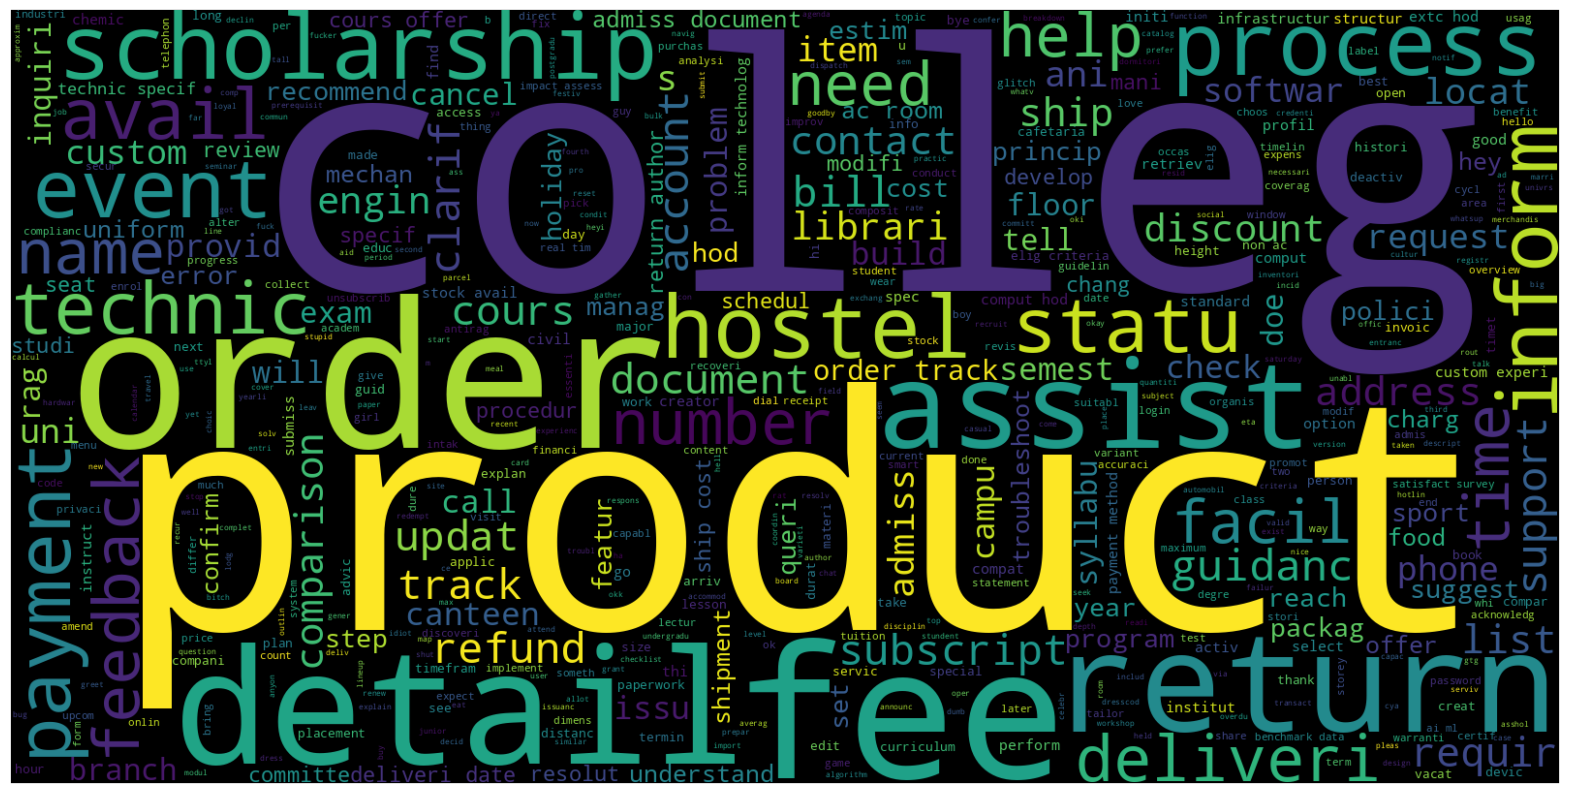

In [18]:
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(df['Pattern']))
plt.imshow(wc, interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.show()

## **3.10 || Distrbution of Number of letters in each text**

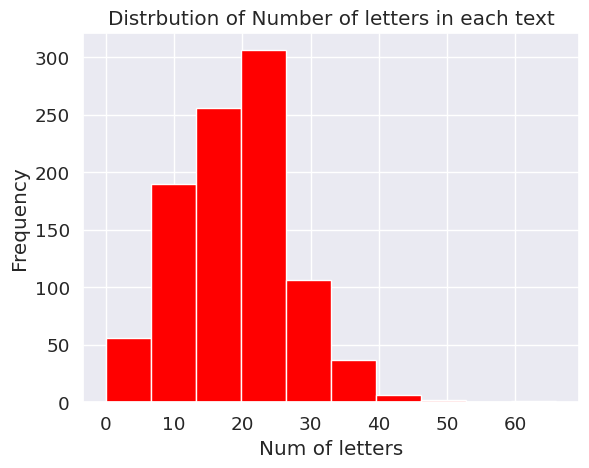

In [19]:
letters_len=df['Pattern'].str.len()
plt.hist(letters_len,color='red')
plt.title("Distrbution of Number of letters in each text")
plt.xlabel("Num of letters")
plt.ylabel("Frequency")
plt.show()

## **3.11 || Distrbution of Number of words in each text¶**

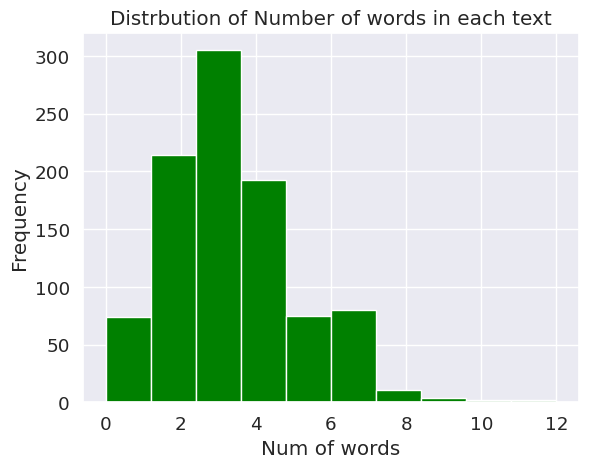

In [20]:
words_len=df['Pattern'].str.split().map(lambda x: len(x))
plt.hist(words_len,color='green')
plt.title("Distrbution of Number of words in each text")
plt.xlabel("Num of words")
plt.ylabel("Frequency")
plt.show()

## **3.12 || Visualize Average word length in each**

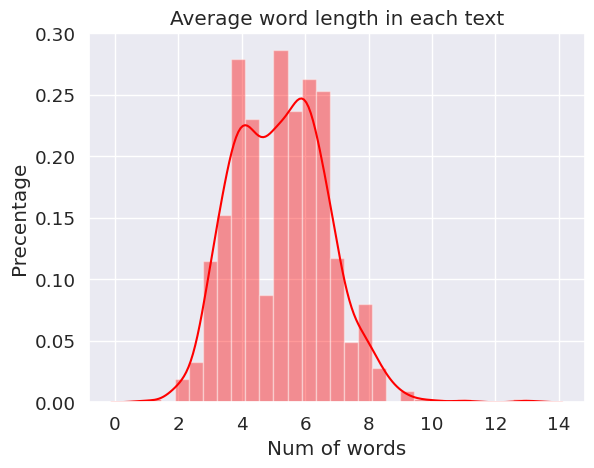

In [21]:
word=df['Pattern'].str.split().apply(lambda x : [len(i) for i in x])
word = word.map(lambda x: np.mean(x))
sns.distplot(word,color='red')
plt.title("Average word length in each text")
plt.xlabel("Num of words")
plt.ylabel("Precentage")
plt.show()

## **3.13 || Visualize top words**

In [22]:
def get_corpus(series):
    words = []
    for text in series:
        for word in text.split():
            words.append(word.strip())
    return words

corpus = get_corpus(df.Pattern)
corpus[:5]

['hi', 'how', 'are', 'you', 'is']

In [23]:
print(f"dataset contains {len(corpus)} words")

dataset contains 3231 words


In [24]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'colleg': 95,
 'product': 84,
 'is': 83,
 'what': 77,
 'the': 71,
 'order': 52,
 'for': 50,
 'of': 48,
 'you': 47,
 'how': 42}

In [25]:
def get_top_text_ngrams(corpus, n,g):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

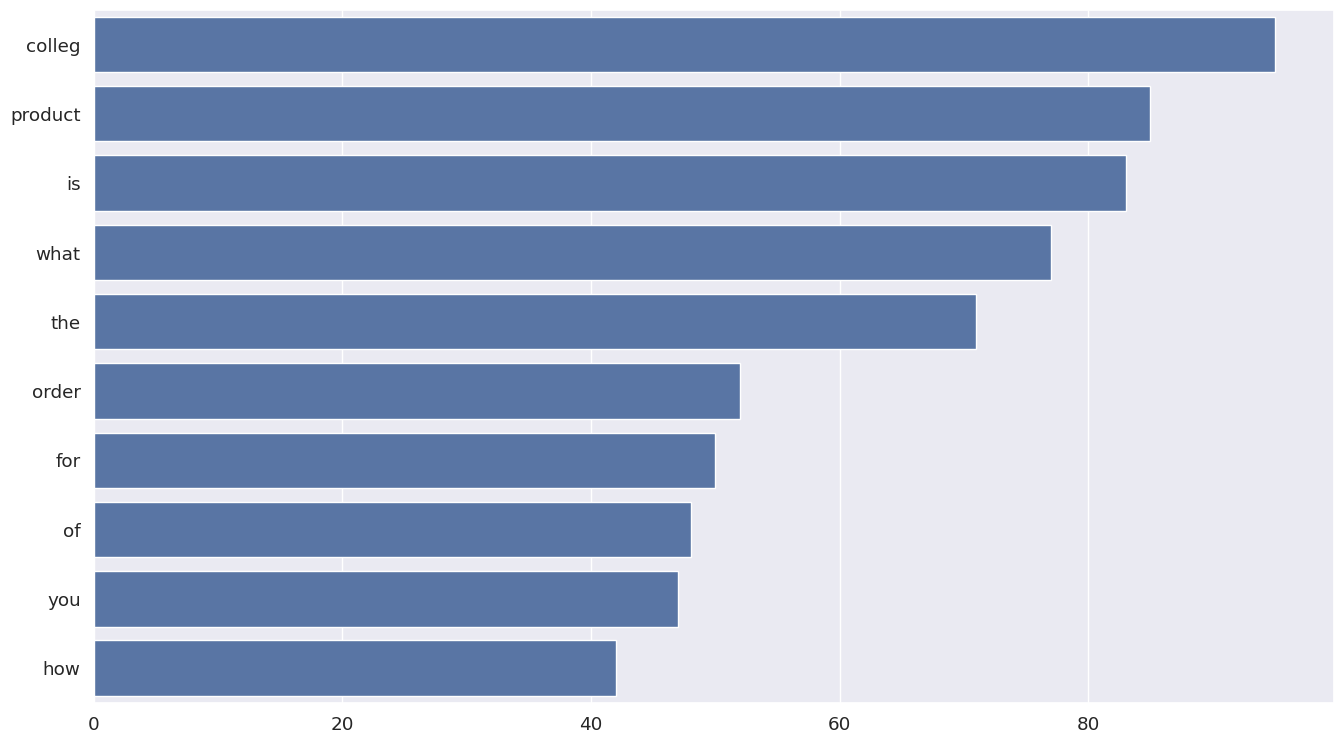

In [26]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.Pattern,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()));

# **4 || Data Preprocessing**


In [27]:
df2.head()

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [28]:
labels = df2['Tag'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['greeting',
 'goodbye',
 'creator',
 'name',
 'hours',
 'number',
 'course',
 'fees',
 'location',
 'hostel',
 'event',
 'document',
 'floors',
 'syllabus',
 'library',
 'infrastructure',
 'canteen',
 'menu',
 'placement',
 'ithod',
 'computerhod',
 'extchod',
 'principal',
 'sem',
 'admission',
 'scholarship',
 'facilities',
 'college intake',
 'uniform',
 'committee',
 'random',
 'swear',
 'vacation',
 'sports',
 'salutaion',
 'task',
 'ragging',
 'hod',
 'order_status',
 'payment_issue',
 'delivery_time',
 'product_availability',
 'return_policy',
 'discount_offer',
 'product_comparison',
 'refund_process',
 'subscription_cancelation',
 'shipping_cost',
 'technical_support',
 'account_management',
 'product_recommendations',
 'order_modification',
 'product_returns',
 'product_information',
 'billing_inquiries',
 'customer_feedback',
 'technical_specifications',
 'order_tracking']

In [29]:
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

In [30]:
id2label

{0: 'greeting',
 1: 'goodbye',
 2: 'creator',
 3: 'name',
 4: 'hours',
 5: 'number',
 6: 'course',
 7: 'fees',
 8: 'location',
 9: 'hostel',
 10: 'event',
 11: 'document',
 12: 'floors',
 13: 'syllabus',
 14: 'library',
 15: 'infrastructure',
 16: 'canteen',
 17: 'menu',
 18: 'placement',
 19: 'ithod',
 20: 'computerhod',
 21: 'extchod',
 22: 'principal',
 23: 'sem',
 24: 'admission',
 25: 'scholarship',
 26: 'facilities',
 27: 'college intake',
 28: 'uniform',
 29: 'committee',
 30: 'random',
 31: 'swear',
 32: 'vacation',
 33: 'sports',
 34: 'salutaion',
 35: 'task',
 36: 'ragging',
 37: 'hod',
 38: 'order_status',
 39: 'payment_issue',
 40: 'delivery_time',
 41: 'product_availability',
 42: 'return_policy',
 43: 'discount_offer',
 44: 'product_comparison',
 45: 'refund_process',
 46: 'subscription_cancelation',
 47: 'shipping_cost',
 48: 'technical_support',
 49: 'account_management',
 50: 'product_recommendations',
 51: 'order_modification',
 52: 'product_returns',
 53: 'product_in

In [31]:
label2id

{'greeting': 0,
 'goodbye': 1,
 'creator': 2,
 'name': 3,
 'hours': 4,
 'number': 5,
 'course': 6,
 'fees': 7,
 'location': 8,
 'hostel': 9,
 'event': 10,
 'document': 11,
 'floors': 12,
 'syllabus': 13,
 'library': 14,
 'infrastructure': 15,
 'canteen': 16,
 'menu': 17,
 'placement': 18,
 'ithod': 19,
 'computerhod': 20,
 'extchod': 21,
 'principal': 22,
 'sem': 23,
 'admission': 24,
 'scholarship': 25,
 'facilities': 26,
 'college intake': 27,
 'uniform': 28,
 'committee': 29,
 'random': 30,
 'swear': 31,
 'vacation': 32,
 'sports': 33,
 'salutaion': 34,
 'task': 35,
 'ragging': 36,
 'hod': 37,
 'order_status': 38,
 'payment_issue': 39,
 'delivery_time': 40,
 'product_availability': 41,
 'return_policy': 42,
 'discount_offer': 43,
 'product_comparison': 44,
 'refund_process': 45,
 'subscription_cancelation': 46,
 'shipping_cost': 47,
 'technical_support': 48,
 'account_management': 49,
 'product_recommendations': 50,
 'order_modification': 51,
 'product_returns': 52,
 'product_inform

In [32]:
df2['labels'] = df2['Tag'].map(lambda x: label2id[x.strip()])
df2.head()

,Pattern,Tag,labels
0,Hi,greeting,0
1,How are you?,greeting,0
2,Is anyone there?,greeting,0
3,Hello,greeting,0
4,Good day,greeting,0


# **5 || Split the data into train and test**

In [33]:
X = list(df2['Pattern'])
X[:5]

['Hi', 'How are you?', 'Is anyone there?', 'Hello', 'Good day']

In [34]:
y = list(df2['labels'])
y[:5]

[0, 0, 0, 0, 0]

In [35]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 123)

## **6 || Load BERT Pretrained model and Tokenizer**

In [36]:
model_name = "bert-base-uncased"
max_len = 256

tokenizer = BertTokenizer.from_pretrained(model_name,
                                          max_length=max_len)

model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=num_labels,
                                                      id2label=id2label,
                                                      label2id = label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **7 || Transform the data into numerical format**

In [37]:
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

In [38]:
full_data = tokenizer(X, truncation=True, padding=True)

## **8 || Build Data Loader**

In [39]:
class DataLoader(Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):

        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):

        return len(self.labels)

In [40]:
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

In [41]:
fullDataLoader = DataLoader(full_data, y_test)

# **9 || Define Evaluation Metrcies**

In [42]:
def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

# **10 || Define Training Arguments**

In [43]:
!pip install transformers[torch]
!pip install accelerate -U

In [44]:
import torch
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from torch.utils.data import Dataset
training_args = TrainingArguments(
    output_dir='./output',
    do_train=True,
    do_eval=True,
    num_train_epochs=30,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.05,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    load_best_model_at_end=True
)


## **11 || Train the model**

In [45]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=test_dataloader,
    compute_metrics= compute_metrics
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,4.022100,3.831047,0.116667,0.027899,0.036699,0.063164
100,3.443800,2.969587,0.429167,0.268242,0.323714,0.318432


## **12 Evaluate the Model**

In [ ]:
q=[trainer.evaluate(eval_dataset=df2) for df2 in [train_dataloader, test_dataloader]]

pd.DataFrame(q, index=["train","test"]).iloc[:,:5]

In [ ]:
def predict(text):

    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")  # Remove .to("cuda")
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label


In [ ]:
text = "Hello"
predict(text)

## **13 Save the Model**

In [ ]:
model_path = "chatbot"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

In [ ]:
!pip install xformers

## **14 Load the Model**

In [ ]:
model_path = "/content/chatbot"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
chatbot= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [ ]:
chatbot("Hello")

## **15 Chat with the Chatbot**

In [ ]:
def chat(chatbot):

    print("Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..")
    print("Type 'quit' to exit the chat\n\n")

    text = input("User: ").strip().lower()

    while(text != 'quit'):

        score = chatbot(text)[0]['score']

        if score < 0.8:
            print("Chatbot: Sorry I can't answer that\n\n")
            text = input("User: ").strip().lower()
            continue

        label = label2id[chatbot(text)[0]['label']]
        response = random.choice(intents['intents'][label]['responses'])

        print(f"Chatbot: {response}\n\n")

        text = input("User: ").strip().lower()

In [ ]:
chat(chatbot)